# 1. INITIAL SETUP

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost lightgbm shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve,
                           confusion_matrix, classification_report)
import shap
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


# 2. DATA LOADING

In [ ]:
# Load and standardize column names
df = pd.read_csv('frailty_dataset_modified.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
print("Columns:", df.columns.tolist())

Columns: ['age', 'living_alone', 'smoking_history', 'depression', 'cardiac_function', 'cerebrovascular_disease', 'diabetes', 'tc', 'ldl_c', 'hemoglobin', 'adl_score', 'frailty']


# 3. DATA PREPROCESSING

In [ ]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

# Handle missing values for NUMERIC columns
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Handle missing values for NON-NUMERIC columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(f"\nCategorical columns: {categorical_cols.tolist()}")

# Option 1: Fill with mode (most frequent value)
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        df[col] = df[col].fillna(mode_value)
        print(f"Filled {col} missing values with mode: {mode_value}")

# Convert cardiac_function to binary (I-II = 0, III-IV = 1)
df['cardiac_function'] = df['cardiac_function'].apply(
    lambda x: 1 if x in ['III–IV', 'III-IV', 'IV'] else 0
)

# Select features and target
features = [
    'age', 'living_alone', 'depression',
    'cardiac_function', 'cerebrovascular_disease',
    'diabetes', 'tc', 'ldl_c', 'hemoglobin', 'adl_score'
]
target = 'frailty'
X = df[features]
y = df[target]

# Train-test split (1:1 ratio)
X_dev, X_val, y_dev, y_val = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y)

# Scale ONLY continuous features
continuous_features = ['age', 'tc', 'ldl_c', 'hemoglobin', 'adl_score']
scaler = StandardScaler()
X_dev[continuous_features] = scaler.fit_transform(X_dev[continuous_features])
X_val[continuous_features] = scaler.transform(X_val[continuous_features])

Missing values:
 age                        0
living_alone               0
smoking_history            0
depression                 0
cardiac_function           0
cerebrovascular_disease    0
diabetes                   0
tc                         0
ldl_c                      0
hemoglobin                 0
adl_score                  0
frailty                    0
dtype: int64

Categorical columns: ['cardiac_function']


# 4. MODEL TRAINING

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=1.0, max_iter=100, random_state=42),
    'XGBoost': XGBClassifier(learning_rate=0.3, max_depth=6, min_child_weight=2, reg_lambda=1, random_state=42),
    'LightGBM': LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=20, max_depth=None, random_state=42),
    'AdaBoost': AdaBoostClassifier(learning_rate=1.0, n_estimators=50, random_state=42)
}

# Enhanced evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    # Full training
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    return {
        'model': model,
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
        'test_auc': roc_auc_score(y_test, y_proba),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'cm': confusion_matrix(y_test, y_pred)
    }

# Train and evaluate all models
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    results[name] = evaluate_model(model, X_dev, y_dev, X_val, y_val)

# Automatically select best model based on test AUC
best_model_name = max(results, key=lambda x: results[x]['test_auc'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} with AUC: {results[best_model_name]['test_auc']:.3f}")


Evaluating Logistic Regression...
Evaluating XGBoost...
Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 241, number of negative: 239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502083 -> initscore=0.008333
[LightGBM] [Info] Start training from score 0.008333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

# 5. VISUALIZATION

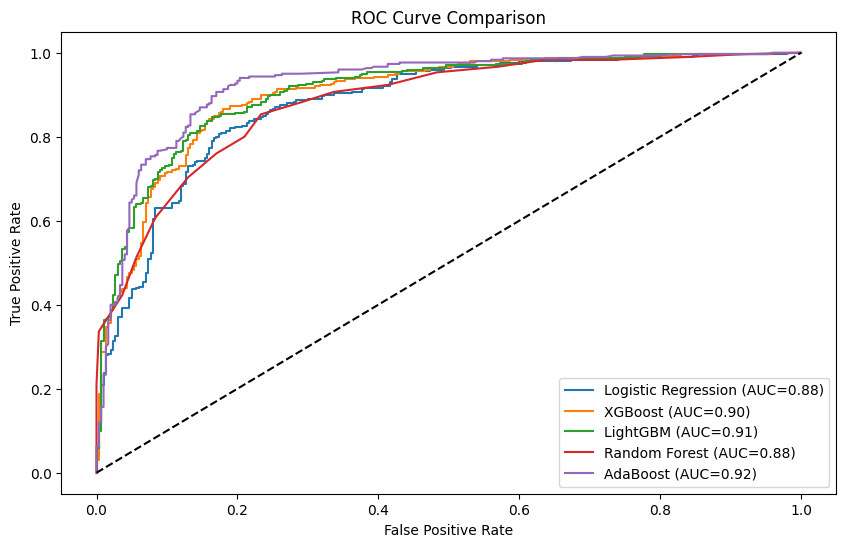


Model Performance Metrics:


,AUC,Accuracy,Precision,Recall,F1 Score
AdaBoost,0.924422,0.850000,0.862069,0.833333,0.847458
LightGBM,0.908711,0.835000,0.823151,0.853333,0.837971
XGBoost,0.902456,0.841667,0.829582,0.860000,0.844517
Random Forest,0.882756,0.795000,0.792079,0.800000,0.796020
Logistic Regression,0.879456,0.813333,0.809211,0.820000,0.814570


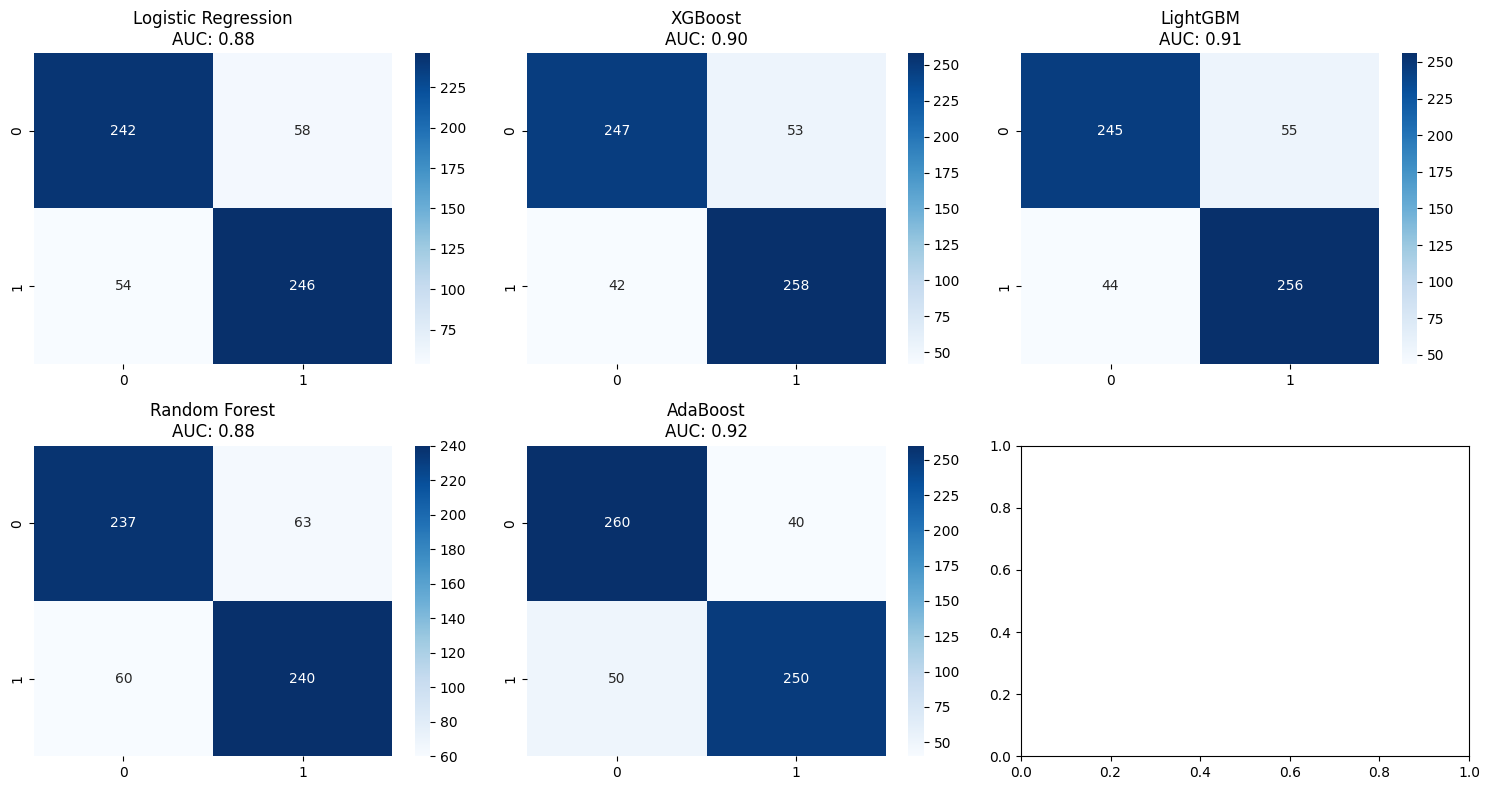

In [ ]:

# ROC Curves Plot
plt.figure(figsize=(10,6))
for name in results.keys():
    model = results[name]['model']
    y_proba = model.predict_proba(X_val)[:,1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={results[name]["test_auc"]:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Performance Metrics Table
metrics_df = pd.DataFrame.from_dict(results, orient='index')
metrics_df = metrics_df[['test_auc', 'accuracy', 'precision', 'recall', 'f1']]
metrics_df.columns = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
print("\nModel Performance Metrics:")
display(metrics_df.sort_values('AUC', ascending=False))

# Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(15,8))
for (name, result), ax in zip(results.items(), axes.flatten()):
    if name in results:  # Safety check
        sns.heatmap(result['cm'], annot=True, fmt='d', ax=ax, cmap='Blues')
        ax.set_title(f"{name}\nAUC: {result['test_auc']:.2f}")
plt.tight_layout()
plt.show()

# 6. MODEL INTERPRETATION


Interpreting best model (AdaBoost)...


  0%|          | 0/100 [00:00<?, ?it/s]

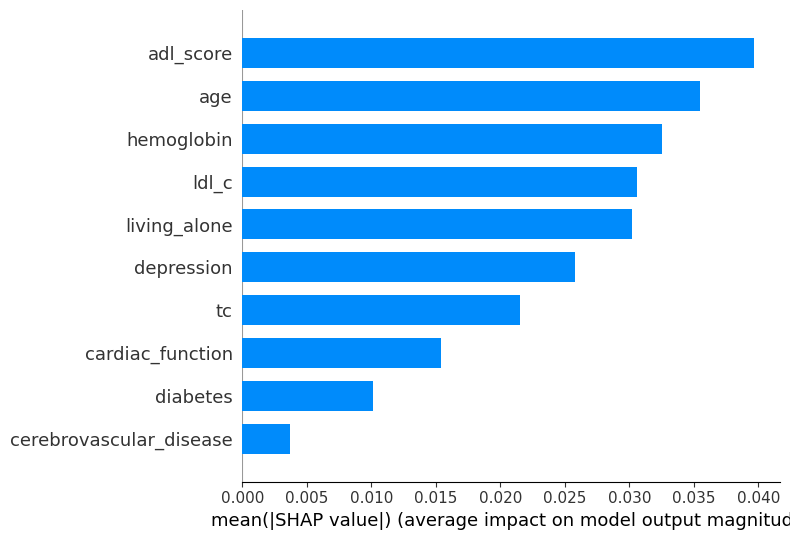

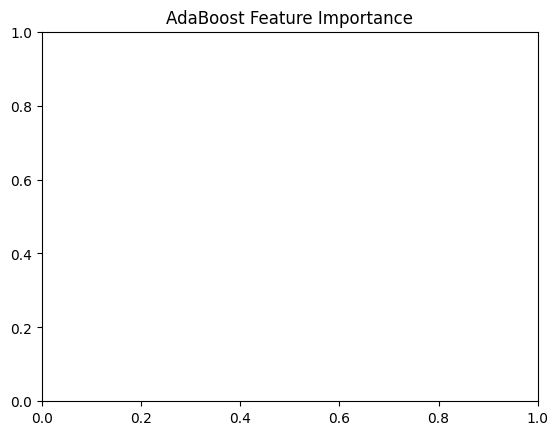

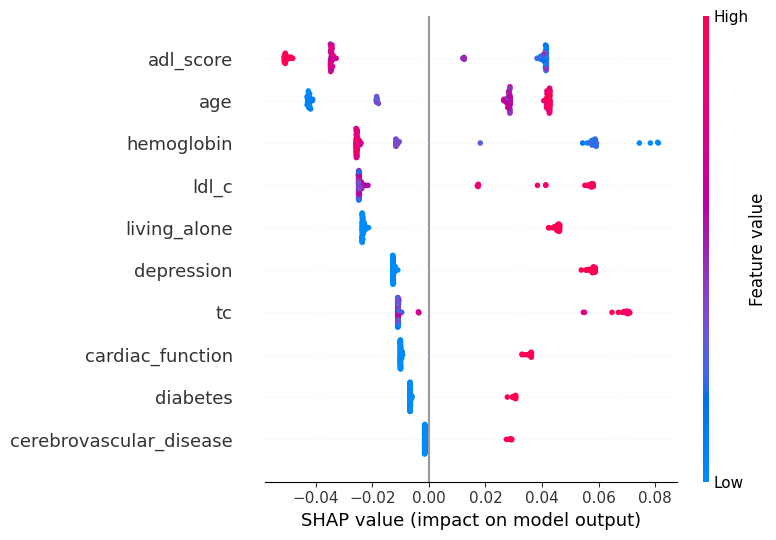

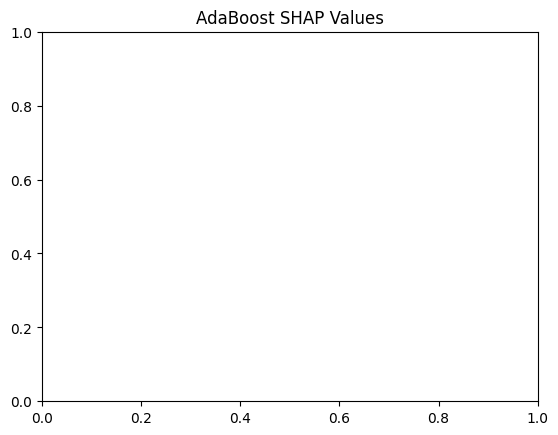

In [ ]:

print(f"\nInterpreting best model ({best_model_name})...")

try:
    # First try KernelExplainer which works with any model
    def model_predict(X):
        return best_model.predict_proba(X)[:,1]  # Probability of positive class

    # Use a sample of background data
    background = shap.sample(X_dev, 100)  # Smaller sample for faster computation

    explainer = shap.KernelExplainer(model_predict, background)
    shap_values = explainer.shap_values(X_dev[:100])  # Explain first 100 instances

    # Plot summary
    plt.figure(figsize=(10,5))
    shap.summary_plot(shap_values, X_dev[:100], feature_names=X_dev.columns, plot_type="bar")
    plt.title(f'{best_model_name} Feature Importance')
    plt.show()

    # Plot detailed SHAP values
    plt.figure(figsize=(10,5))
    shap.summary_plot(shap_values, X_dev[:100], feature_names=X_dev.columns, plot_type="dot")
    plt.title(f'{best_model_name} SHAP Values')
    plt.show()

except Exception as e:
    print(f"Could not create SHAP explanation: {str(e)}")
    print("\nAlternative: Showing Feature Importances")

    # Fallback to standard feature importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10,5))
        plt.title("Feature Importances")
        plt.bar(range(X_dev.shape[1]), importances[indices], align="center")
        plt.xticks(range(X_dev.shape[1]), X_dev.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("No feature importances available for this model type")

# 7. FINAL EVALUATION


BEST MODEL PERFORMANCE (AdaBoost)
----------------------------------------
Test AUC:       0.924
CV AUC (mean):  0.922 ± 0.029
Accuracy:       0.850
Precision:      0.862
Recall:         0.833
F1 Score:       0.847

Confusion Matrix:
[[260  40]
 [ 50 250]]



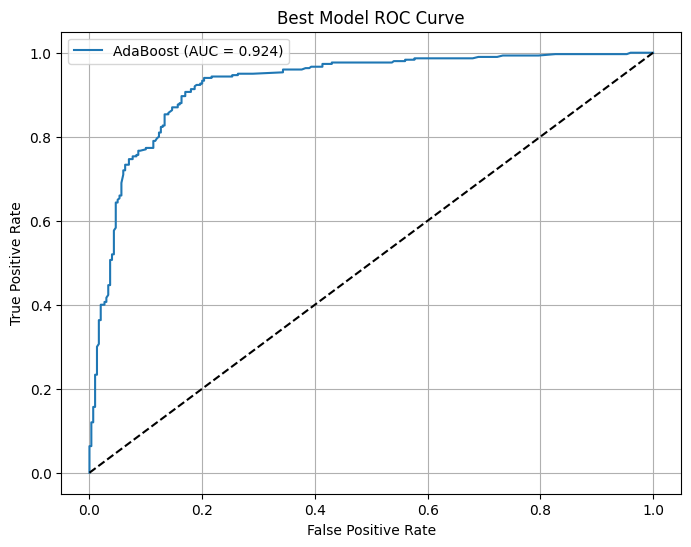

In [ ]:

# Get metrics for best model
final_metrics = results[best_model_name]

print(f"""
BEST MODEL PERFORMANCE ({best_model_name})
----------------------------------------
Test AUC:       {final_metrics['test_auc']:.3f}
CV AUC (mean):  {final_metrics['cv_auc_mean']:.3f} ± {final_metrics['cv_auc_std']:.3f}
Accuracy:       {final_metrics['accuracy']:.3f}
Precision:      {final_metrics['precision']:.3f}
Recall:         {final_metrics['recall']:.3f}
F1 Score:       {final_metrics['f1']:.3f}

Confusion Matrix:
{final_metrics['cm']}
""")

# Plot final ROC curve
plt.figure(figsize=(8,6))
y_proba = best_model.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {final_metrics["test_auc"]:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best Model ROC Curve')
plt.legend()
plt.grid()
plt.show()